# Measuring class label shift

In [1]:
import matplotlib.pyplot as plt

from csbm import MultiClassCSBM, ClassCSBM
from measures import total_variation_distance

In [3]:
from numpy.random import gamma
import numpy as np
import math

23.315885977748128


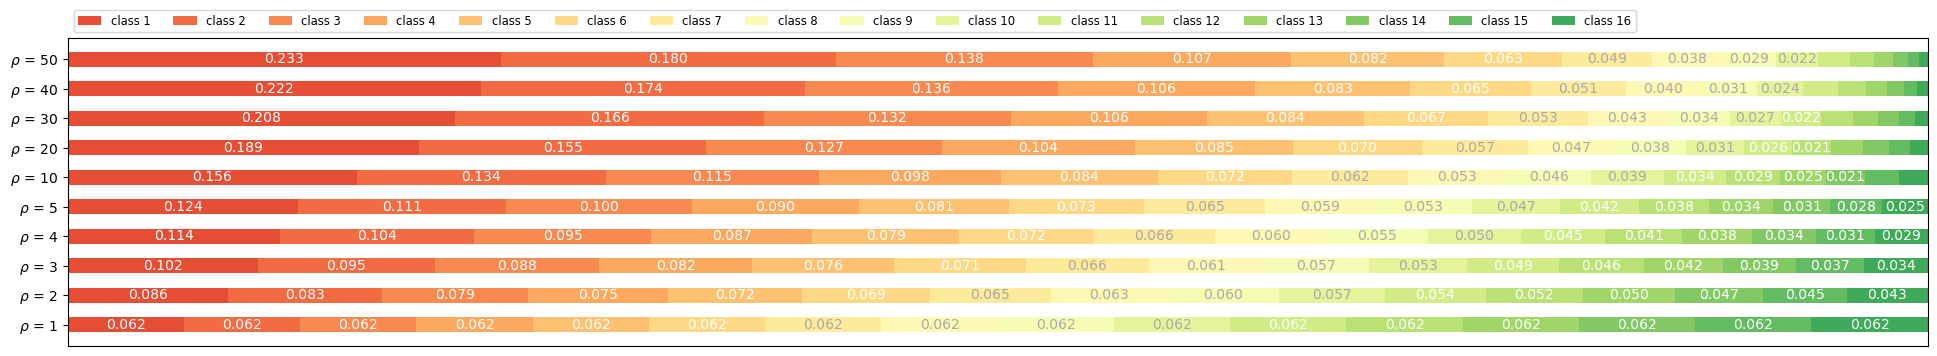

In [4]:
K = 16
category_names = [f'class {i+1}' for i in range(K)]
results = {}
for i in reversed([1, 2, 3, 4, 5, 10, 20, 30, 40, 50]):
    rho = i
    class_dist = []
    for k in range(K):
        class_dist.append(math.pow(1 / rho, k / (K - 1)))
    s = sum(class_dist)
    class_dist = [p / s for p in class_dist]
    results[r'$\rho$ = ' + str(rho)] = class_dist
print(results[r'$\rho$ = ' + str(50)][-1] * 5000)

def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(24, 4))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, labels=[f'{val:.3f}' if val >= 0.02 else '' for val in widths], label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


survey(results, category_names)
plt.savefig('class_label_shift.pdf', format='pdf')
plt.show()

In [3]:
classCSBM = ClassCSBM(n=50)
print(classCSBM.p)
for i in range(9):
    classCSBM.evolve()
    print(classCSBM.p)

[0.23315886 0.17963347 0.1383957  0.10662472 0.08214729 0.06328905
 0.04876003 0.03756637 0.0289424  0.02229821 0.01717929 0.01323551
 0.01019708 0.00785618 0.00605266 0.00466318]
[0.22236652 0.17388631 0.13597573 0.10633039 0.0831483  0.06502036
 0.05084467 0.03975954 0.03109119 0.02431271 0.01901207 0.01486707
 0.01162576 0.00909112 0.00710908 0.00555916]
[0.20841491 0.16613228 0.13242784 0.10556125 0.08414528 0.06707413
 0.05346632 0.04261922 0.03397276 0.02708046 0.02158645 0.01720705
 0.01371614 0.01093345 0.0087153  0.00694716]
[0.18876589 0.15459242 0.12660558 0.10368538 0.08491457 0.06954195
 0.05695233 0.0466419  0.03819802 0.03128279 0.02561947 0.02098142
 0.01718302 0.01407227 0.01152468 0.00943829]
[0.15565453 0.13350425 0.11450605 0.09821137 0.08423549 0.07224843
 0.06196718 0.053149   0.04558568 0.03909865 0.03353475 0.02876262
 0.02466958 0.021159   0.01814799 0.01556545]
[0.12402069 0.11140281 0.10006867 0.08988767 0.08074249 0.07252774
 0.06514876 0.05852051 0.05256663

In [2]:
n = 80
c = 8
t = 17

In [4]:
csbm = MultiClassCSBM(n=n, classes=c)
csbm_class = ClassLabelCSBM(n=n, classes=c)

initial_p = csbm_class.p
current_p = [0] * c
for label in csbm.y:
    current_p[label] += 1

time_steps = [1]
tvd_const = [csbm.get_class_label_shift_tvd()]
tvd_class = [csbm_class.get_class_label_shift_tvd()]
tvd_p = [total_variation_distance(initial_p, csbm_class.p)]
tvd_total = [total_variation_distance([label / n for label in current_p], [label / n for label in current_p])]

In [5]:
for tau in range(2, t + 1):
    time_steps.append(tau)
    
    csbm.evolve()
    tvd_const.append(csbm.get_class_label_shift_tvd())

    csbm_class.evolve()
    tvd_class.append(csbm_class.get_class_label_shift_tvd())
    tvd_p.append(total_variation_distance(initial_p, csbm_class.p))
    for label in csbm_class.y[-n:]:
        current_p[label] += 1
    tvd_total.append(total_variation_distance(initial_p, [label / tau / n for label in current_p]))

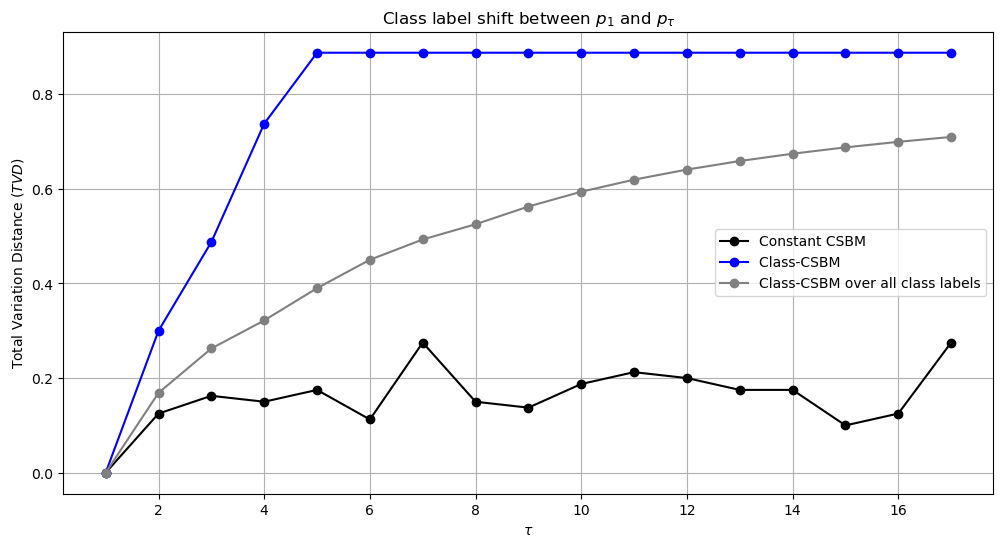

In [12]:
plt.figure(figsize=(12, 6))
plt.title(r'Class label shift between $p_{1}$ and $p_{\tau}$')
plt.plot(time_steps, tvd_const, marker='o', linestyle='-', color='black', label='Constant CSBM')
plt.plot(time_steps, tvd_class, marker='o', linestyle='-', color='b', label=r'Class-CSBM ')
plt.plot(time_steps, tvd_total, marker='o', linestyle='-', color='gray', label='Class-CSBM over all class labels')
plt.xlabel(r'$\tau$')
plt.ylabel('Total Variation Distance $(TVD)$')
plt.grid(True)
plt.legend(loc='center right')
plt.savefig('class_label_shift.pdf', format='pdf')
plt.show()